# Distracted Driver Detection

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

## Automatically detect drivers engaging in distracted behaviors, given a dataset of 2D dashboard camera images

# Create Validation Set

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import os

In [2]:
%pwd

'/home/paperspace/Repos/Statefarm'

In [1]:
from shutil import copyfile, move
import pandas as pd
from glob import glob
import os
import numpy as np

In [2]:
path = '/home/paperspace/Repos/Statefarm/data/'

In [5]:
%cd data/train 

/home/paperspace/Repos/Statefarm/data/train


In [6]:
%ls

c0/  c1/  c2/  c3/  c4/  c5/  c6/  c7/  c8/  c9/


In [7]:
%mkdir ../valid

In [8]:
for i in glob('c?'):
    os.mkdir('../valid/'+i)

In [9]:
dil = pd.read_csv(path + 'compressed/driver_imgs_list.csv')

In [10]:
dil.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [11]:
# get all different drivers from file and select 5 randomely
# group by subject
allClasses=glob('c?')
allDrivers = dil['subject'].drop_duplicates().as_matrix()
randValidationDrivers = np.random.choice(allDrivers, 5)
print(randValidationDrivers)
print(allClasses)

['p056' 'p052' 'p081' 'p045' 'p049']
['c7', 'c5', 'c1', 'c8', 'c3', 'c2', 'c6', 'c4', 'c0', 'c9']


In [12]:
totalPicMoved=0

for driveClass in allClasses:
    perClassSeries = dil['classname'].isin([driveClass])
    picPerClass = dil[perClassSeries]

    for driver in randValidationDrivers:
        perDriverPic =  picPerClass['subject'].isin([driver])
        picPerDriverInClass = picPerClass[perDriverPic]
        picArray = picPerDriverInClass['img'].as_matrix()
        #select 20% random photos and move it
        #numOfValidPic = int(len(picArray)*0.2)
        
        #print 'num of valid pic ' + str(numOfValidPic) + '/' + str(len(picArray))
        #print ('num of valid pic '+str(numOfValidPic)+ '/'+ str(len(picArray)))
        
        #validationPicArr=np.random.choice(picArray,numOfValidPic)
        
        shuf = np.random.permutation(picArray)
        for pic in  shuf: move(driveClass +'/'+ pic, path+'valid/'+ driveClass +'/'+pic)
            
        totalPicMoved += len(shuf)
        
print ('totalt pic moved: '+ str(totalPicMoved))

totalt pic moved: 4092


In [13]:
%pwd

'/home/paperspace/Repos/Statefarm/data/train'

# Create a sample

In [14]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [15]:
for d in glob('c?'):
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [16]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1500): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [17]:
%cd /home/paperspace/Repos/Statefarm/data/valid

/home/paperspace/Repos/Statefarm/data/valid


In [18]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): copyfile(shuf[i], '../sample/valid/' + shuf[i])

# Models

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Flatten, Dropout
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
img_height, img_width = 224, 224
nb_channels = 3
batch_size = 16

In [5]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [6]:
def get_batches(dirname, gen=ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


def onehot(x):
    return to_categorical(x)

def get_classes(path):
    batches = get_batches(path+'train', shuffle=False, batch_size=1)
    val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
    test_batches = get_batches(path+'test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
val_batches.filenames, batches.filenames, test_batches.filenames)

## Linear Model

In [7]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(img_height, img_width, nb_channels)),
        Flatten(),
        Dense(10, activation='softmax')
    ])

In [9]:
train_generator = train_datagen.flow_from_directory(path+'sample/train', # this is the target directory 
                                                    target_size=(img_height, img_width), # all images will be resized to 299x299
                                                    batch_size=16, 
                                                    class_mode='categorical') # since we use categorical_crossentropy loss, we need categorical labels
validation_generator = test_datagen.flow_from_directory(path+'sample/valid', 
                                                        target_size=(img_height, img_width), 
                                                        batch_size=16, 
                                                        class_mode='categorical')

Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [12]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.samples // batch_size, 
                              epochs=2, 
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.samples // batch_size)

Epoch 1/2
93/93 [==============================] - 15s - loss: 14.0285 - acc: 0.1196 - val_loss: 14.4770 - val_acc: 0.1018
Epoch 2/2
93/93 [==============================] - 11s - loss: 14.2902 - acc: 0.1131 - val_loss: 14.4770 - val_acc: 0.1018


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1505290   
Total params: 1,506,186
Trainable params: 1,505,738
Non-trainable params: 448
_________________________________________________________________


Over 1.5 million parameters - that should be enough!

In [14]:
np.round(model.predict_generator(train_generator, steps=16)[:10],2)

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [15]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(img_height, img_width, nb_channels)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.samples // batch_size, 
                              epochs=2, 
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.samples // batch_size)

Epoch 1/2
93/93 [==============================] - 11s - loss: 1.9944 - acc: 0.3235 - val_loss: 2.9559 - val_acc: 0.1966
Epoch 2/2
93/93 [==============================] - 11s - loss: 1.0940 - acc: 0.6763 - val_loss: 1.9479 - val_acc: 0.3891


In [16]:
model.optimizer.lr=0.001

In [18]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.samples // batch_size, 
                              epochs=4, 
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.samples // batch_size)

Epoch 1/4
93/93 [==============================] - 11s - loss: 0.7379 - acc: 0.7993 - val_loss: 1.9065 - val_acc: 0.4073
Epoch 2/4
93/93 [==============================] - 11s - loss: 0.4921 - acc: 0.9059 - val_loss: 1.6064 - val_acc: 0.4688
Epoch 3/4
93/93 [==============================] - 11s - loss: 0.3838 - acc: 0.9261 - val_loss: 1.5587 - val_acc: 0.5010
Epoch 4/4
93/93 [==============================] - 11s - loss: 0.3034 - acc: 0.9521 - val_loss: 1.5804 - val_acc: 0.4970


We're stabilizing at validation accuracy of around 0.50

In [19]:
rnd_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=True)

Found 4092 images belonging to 10 classes.


In [21]:
val_res = [model.evaluate_generator(rnd_batches, rnd_batches.samples) for i in range(10)]
np.round(val_res, 2)

KeyboardInterrupt: 

## Single conv layer

In [22]:
def conv1(train_gen):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(224,224, 3)),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ])
    
    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(train_gen, 
                              steps_per_epoch=train_generator.samples // batch_size, 
                              epochs=2, 
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.samples // batch_size)
    model.optimizer.lr = 0.001
    model.fit_generator(train_gen, 
                              steps_per_epoch=train_generator.samples // batch_size, 
                              epochs=4, 
                              validation_data=validation_generator, 
                              validation_steps=validation_generator.samples // batch_size)
    return model

In [24]:
batches = get_batches(path+'train', batch_size=batch_size, shuffle=True)

Found 18332 images belonging to 10 classes.


In [25]:
conv1(batches)

Epoch 1/2
93/93 [==============================] - 46s - loss: 1.4485 - acc: 0.5618 - val_loss: 1.5896 - val_acc: 0.5161
Epoch 2/2
93/93 [==============================] - 45s - loss: 0.4926 - acc: 0.8636 - val_loss: 1.7906 - val_acc: 0.3974
Epoch 1/4
93/93 [==============================] - 45s - loss: 0.2546 - acc: 0.9402 - val_loss: 1.4526 - val_acc: 0.5478
Epoch 2/4
93/93 [==============================] - 45s - loss: 0.1720 - acc: 0.9550 - val_loss: 1.5624 - val_acc: 0.5285
Epoch 3/4
93/93 [==============================] - 45s - loss: 0.1406 - acc: 0.9671 - val_loss: 1.4546 - val_acc: 0.5010
Epoch 4/4
93/93 [==============================] - 45s - loss: 0.1097 - acc: 0.9724 - val_loss: 1.5640 - val_acc: 0.5325


This model is overfitting heavily, the first step to reducde this is using data augmentation

# Data Augmentation

In [26]:
gen_t = ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 18332 images belonging to 10 classes.


Examples of randomly augmented images

In [ ]:
test_datagen.flow_from_directory(path+'sample/valid', 
                                                        target_size=(img_height, img_width), 
                                                        batch_size=16, 
                                                        class_mode='categorical')

In [39]:
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [42]:
%pwd

'/home/paperspace/Repos/Statefarm'

In [48]:
img = load_img('/home/paperspace/Repos/Statefarm/data/valid/c0/img_80488.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in gen_t.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='driver', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [49]:
import cv2

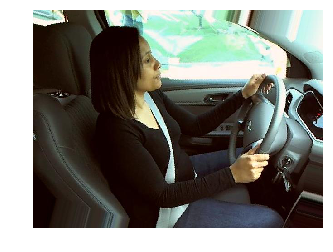

In [51]:
image = cv2.imread("preview/driver_0_1075.jpeg")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

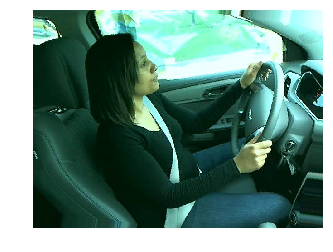

In [52]:
image = cv2.imread("preview/driver_0_3368.jpeg")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

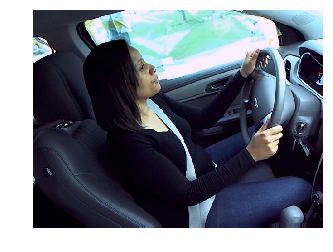

In [53]:
image = cv2.imread("preview/driver_0_7066.jpeg")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [54]:
model = conv1(batches)

Epoch 1/2
93/93 [==============================] - 46s - loss: 2.2815 - acc: 0.2681 - val_loss: 2.2630 - val_acc: 0.1159
Epoch 2/2
93/93 [==============================] - 45s - loss: 1.7800 - acc: 0.4019 - val_loss: 1.8487 - val_acc: 0.2782
Epoch 1/4
93/93 [==============================] - 45s - loss: 1.6174 - acc: 0.4651 - val_loss: 1.5917 - val_acc: 0.4533
Epoch 2/4
93/93 [==============================] - 45s - loss: 1.4219 - acc: 0.5302 - val_loss: 1.4933 - val_acc: 0.4715
Epoch 3/4
93/93 [==============================] - 45s - loss: 1.2575 - acc: 0.5874 - val_loss: 1.4395 - val_acc: 0.5295
Epoch 4/4
93/93 [==============================] - 45s - loss: 1.1616 - acc: 0.6136 - val_loss: 1.4295 - val_acc: 0.5691


In [59]:
val_batches = get_batches(path+'valid', test_datagen, batch_size=batch_size)

Found 4092 images belonging to 10 classes.


In [61]:
model.optimizer.lr = 0.0001
model.fit_generator(batches, batches.samples // batch_size, nb_epoch=5, validation_data=val_batches, 
                 nb_val_samples=val_batches.samples // batch_size)

/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., 1145, epochs=5, validation_steps=255, validation_data=<keras.pre...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
1145/1145 [==============================] - 465s - loss: 0.8461 - acc: 0.7309 - val_loss: 0.8914 - val_acc: 0.7377
Epoch 2/5
1145/1145 [==============================] - 464s - loss: 0.5712 - acc: 0.8303 - val_loss: 0.9792 - val_acc: 0.6632
Epoch 3/5
1145/1145 [==============================] - 464s - loss: 0.4397 - acc: 0.8717 - val_loss: 0.8919 - val_acc: 0.7085
Epoch 4/5
1145/1145 [==============================] - 464s - loss: 0.3487 - acc: 0.9020 - val_loss: 0.7349 - val_acc: 0.7650
Epoch 5/5
1145/1145 [==============================] - 465s - loss: 0.2970 - acc: 0.9112 - val_loss: 0.7512 - val_acc: 0.7507


## Using ImageNet features

From now on we'll be training on the full dataset

In [80]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [8]:
last_conv_idx = [i for i,l in enumerate(conv_base.layers) if type(l) is Conv2D][-1]
conv_layers = conv_base.layers[:last_conv_idx+1]

In [9]:
conv_model = Sequential(conv_layers)

In [26]:
# batches shuffle must be set to False when pre-computing features
batches = get_batches(path+'train', batch_size=batch_size, shuffle=False)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False)

Found 18332 images belonging to 10 classes.
Found 4092 images belonging to 10 classes.


In [27]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 18332 images belonging to 10 classes.
Found 4092 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [28]:
conv_feat = conv_model.predict_generator(batches, batches.samples // batch_size + 1)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.samples // batch_size + 1)

In [29]:
np.save('conv_feat.npy', conv_feat)
np.save('conv_val_feat.npy', conv_val_feat)

In [30]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]

In [31]:
p=0.5

In [32]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))

/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 18332 samples, validate on 4092 samples
Epoch 1/1
18332/18332 [==============================] - 54s - loss: 0.4783 - acc: 0.8539 - val_loss: 0.6456 - val_acc: 0.8087


In [35]:
bn_model.save_weights(path+'conv1.h5')

In [ ]:
bn_model.optimizer.lr=0.01

In [36]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 18332 samples, validate on 4092 samples
Epoch 1/3
  208/18332 [..............................] - ETA: 16s - loss: 0.1109 - acc: 0.9760

/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


18332/18332 [==============================] - 16s - loss: 0.0806 - acc: 0.9761 - val_loss: 0.7409 - val_acc: 0.7923
Epoch 2/3
18332/18332 [==============================] - 16s - loss: 0.0628 - acc: 0.9806 - val_loss: 0.7051 - val_acc: 0.8094
Epoch 3/3
18332/18332 [==============================] - 18s - loss: 0.0517 - acc: 0.9847 - val_loss: 0.7497 - val_acc: 0.8130


In [37]:
bn_model.save_weights(path+'conv2.h5')

# Visualization

In [81]:
model = conv_base

In [92]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [82]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [83]:
# This will be the input image:
img_path = '/home/paperspace/Repos/Statefarm/data/valid/c0/img_80488.jpg' # We preprocess the image into a 4D tensor 
from keras.preprocessing import image
import numpy as np 
img = image.load_img(img_path, target_size=(224, 224)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
# Remember that the model was trained on inputs 
# that were preprocessed in the following way: 
img_tensor /= 255. # Its shape is (1, 150, 150, 3) 
print(img_tensor.shape)

(1, 224, 224, 3)


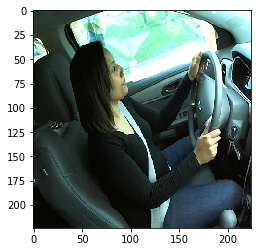

In [84]:
# displaying the picture
import matplotlib.pyplot as plt 
plt.imshow(img_tensor[0])

In [94]:
from keras import layers
from keras import models 
# Extracts the outputs of the top 8 layers: 
layer_outputs = [layer.output for layer in model.layers[:8]] 
# Creates a model that will return these outputs, given the model input: 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [95]:
# This will return a list of 5 Numpy arrays: 
# one array per layer activation 
activations = activation_model.predict(img_tensor)

In [96]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 224, 224, 3)


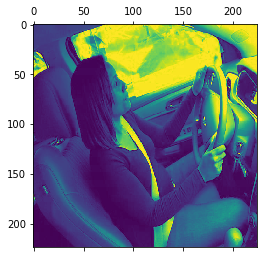

In [97]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

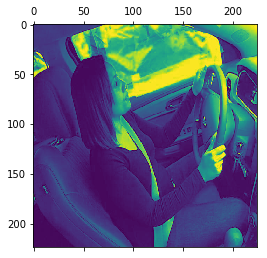

In [98]:
plt.matshow(first_layer_activation[0, :, :, 0], cmap='viridis')

/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  'bottom=%s, top=%s') % (bottom, top))
/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/paperspace/anaconda3/envs/yolo/lib/python3.5/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

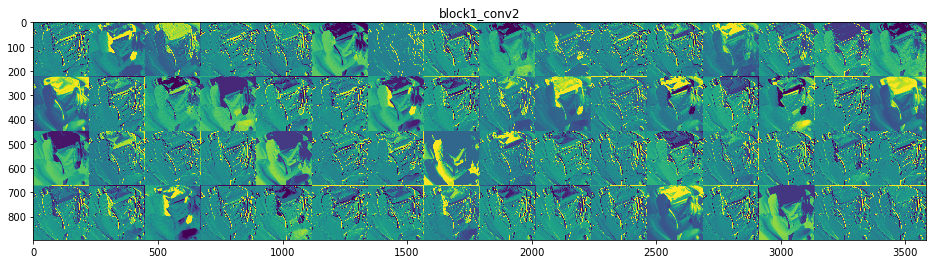

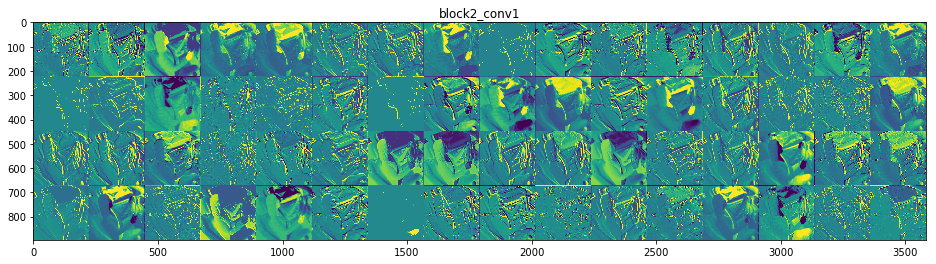

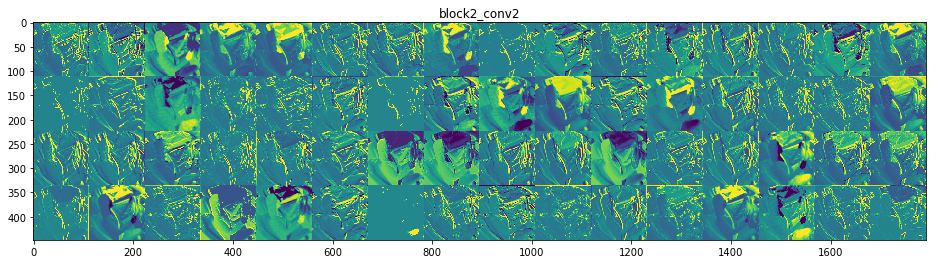

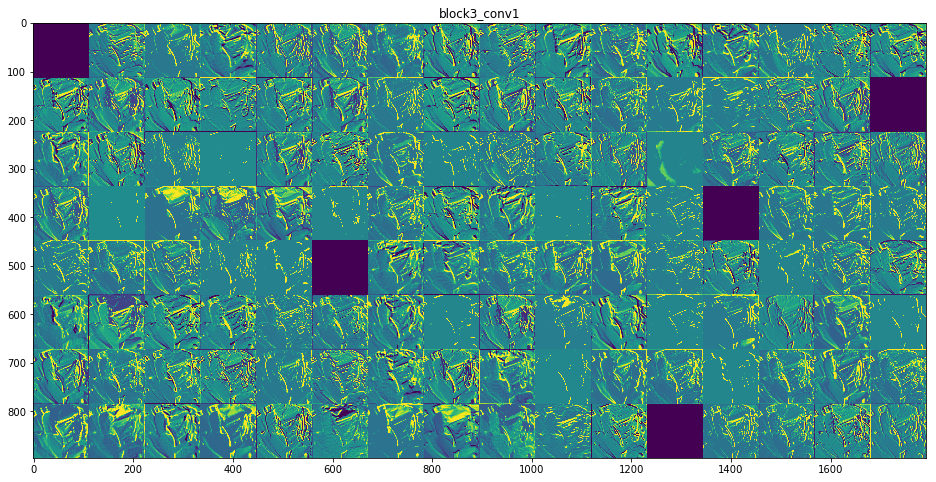

In [93]:
# These are the names of the layers, so can have them as part of our plot 
layer_names = [] 
for layer in model.layers[:8]:
    if isinstance(layer, layers.Conv2D): 
        layer_names.append(layer.name) 

images_per_row = 16 

# Now let's display our feature maps 
for layer_name, layer_activation in zip(layer_names, activations): 
    # This is the number of features in the feature map 
    n_features = layer_activation.shape[-1] 
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1] 
    # We will tile the activation channels in this matrix 
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size * n_cols, images_per_row * size)) 
    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row): 
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable 
            channel_image -= channel_image.mean() 
            channel_image /= channel_image.std() 
            channel_image *= 64 
            channel_image += 128 
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image 
    # Display the grid 
    scale = 1. / size 
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) 
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Visualizing heatmaps of class activation

In [118]:
from keras.applications.vgg16 import VGG16 
model = VGG16(weights='imagenet')

In [119]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions 
import numpy as np # the local path to our target image 
img_path = '/home/paperspace/Repos/Statefarm/data/valid/c0/img_80488.jpg'
# `img` is a PIL image of size 224x224 
img = image.load_img(img_path, target_size=(224, 224)) 
# `x` is a float32 Numpy array of shape (224, 224, 3) 
x = image.img_to_array(img) # we add a dimension to transform our array into a "batch" 
# of size (1, 224, 224, 3) 
x = np.expand_dims(x, axis=0) 
# finally we preprocess the batch 
# (this does channel-wise color normalization) 
x = preprocess_input(x)

In [120]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04162706', 'seat_belt', 0.86953408), ('n03100240', 'convertible', 0.032543764), ('n03770679', 'minivan', 0.026379662)]


In [121]:
np.argmax(preds[0])

785

In [124]:
from keras import backend as K

In [125]:
# To visualize which parts of our image were the most "African elephant"-like, let’s set up the Grad-CAM process:
# this is the "african elephant" entry in the prediction vector 
african_elephant_output = model.output[:, 785] 

# the is the output feature map of the `block5_conv3` layer, 
# the last convolutional layer in VGG16 
last_conv_layer = model.get_layer('block5_conv3') 

# this is the gradient of the "african elephant" class with regard to 
# the output feature map of `block5_conv3` 
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] 

# this is a vector of shape (512,), where each entry 
# is the mean intensity of the gradient over a specific feature map channel 
pooled_grads = K.mean(grads, axis=(0, 1, 2)) 

# this function allows us to access the values of the quantities we just defined: 
# `pooled_grads` and the output feature map of `block5_conv3`, 
# given a sample image 
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) 

# these are the values of these two quantities, as Numpy arrays, 
# given our sample image of two elephants 
pooled_grads_value, conv_layer_output_value = iterate([x]) 

# we multiply each channel in the feature map array 
# by "how important this channel is" with regard to the elephant class 
for i in range(512): 
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
# the channel-wise mean of the resulting feature map 
# is our heatmap of class activation 
heatmap = np.mean(conv_layer_output_value, axis=-1)

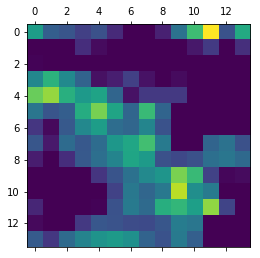

In [126]:
heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 
plt.matshow(heatmap)

In [127]:
# Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:
import cv2 

# we use cv2 to load the original image 
img = cv2.imread(img_path) 

# we resize the heatmap to have the same size as the original image 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) 

# we convert the heatmap to RGB 
heatmap = np.uint8(255 * heatmap) 

# we apply the heatmap to the original image 
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) 

# 0.4 here is a heatmap intensity factor 
superimposed_img = heatmap * 0.4 + img 

# save the image to disk 
cv2.imwrite('driver_cam.jpg', superimposed_img)

True

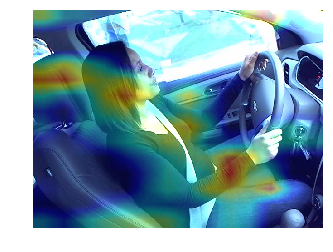

In [132]:
image = cv2.imread("driver_cam.jpg")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()